# Personal Experiments

Visualize mel, prediction errors

In [ ]:
import os
import json

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import librosa

In [3]:
from dataset import LJSpeech
from model import DiffWave
from config import Config
from train import Trainer

In [4]:
if not os.path.exists('./sample'):
    os.makedirs('./sample')

## Loading checkpoints

Load configuration and tf checkpoints.

In [5]:
with open('./ckpt/l1.json') as f:
    config = Config.load(json.load(f))

In [6]:
dummy_optim = tf.keras.optimizers.Adam()
diffwave = DiffWave(config.model)
diffwave.restore('./ckpt/l1/l1_500000.ckpt-1', optim=dummy_optim)

## Prepare test data

Load randomly selected test datum

In [7]:
lj = LJSpeech(config.data)

In [8]:
offset = config.train.split + np.random.randint(100)
offset

13051

In [9]:
speech = next(iter(lj.rawset.skip(offset)))
speech = speech[:speech.shape[0] // config.data.hop * config.data.hop]
speech.shape

TensorShape([197888])

In [10]:
librosa.output.write_wav('./sample/origin.wav', speech.numpy(), config.data.sr)

&lt;matplotlib.image.AxesImage at 0x18aafec9518&gt;

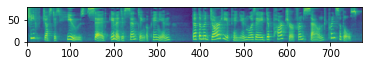

In [11]:
_, logmel = lj.mel_fn(speech[None])
plt.imshow(logmel[0].numpy().T, origin='lower')

## Step-wise Inference

Inference audio from noise step by step.

In [12]:
noise = tf.random.normal(tf.shape(speech[None]))
librosa.output.write_wav('./sample/noise.wav', noise[0].numpy(), config.data.sr)

In [13]:
beta = config.model.beta().astype(np.float32)
alpha = 1 - beta
alpha_bar = np.cumprod(alpha)

In [15]:
pred = []
diffused, denoised, inferenced = [speech[None].numpy()], [], []

base = tf.ones([tf.shape(noise)[0]], dtype=tf.int32)
for level in range(1, config.model.iter + 1):
    estim = diffwave.pred_noise(diffused[-1], base * level, logmel)
    pred.append(estim.numpy())

    sample, _ = diffwave.diffusion(speech[None], alpha_bar[level - 1].item(), noise)
    diffused.append(sample.numpy())

    m, s = diffwave.pred_signal(
        sample, noise, alpha[level - 1], alpha_bar[level - 1])
    sample = m + tf.random.normal(tf.shape(sample)) * s
    denoised.append(sample.numpy())

    m, s = diffwave.pred_signal(
        diffused[-1], estim, alpha[level - 1], alpha_bar[level - 1])
    sample = m + tf.random.normal(tf.shape(sample)) * s
    inferenced.append(sample.numpy())

    librosa.output.write_wav(
        './sample/diffusion{}.wav'.format(level),
        diffused[-1][0], config.data.sr)
    librosa.output.write_wav(
        './sample/denoised{}.wav'.format(level),
        denoised[-1][0], config.data.sr)
    librosa.output.write_wav(
        './sample/inferenced{}.wav'.format(level),
        inferenced[-1][0], config.data.sr)

## Autoregressive Inference

Inference denoised signal autoregressivly

In [16]:
out, ir = diffwave(logmel, diffused[-1])
for i, sample in enumerate(ir[::-1]):
    librosa.output.write_wav(
        './sample/out{}.wav'.format(i),
        sample[0], config.data.sr)

## Plot err and noise levels

Plt errors between predicted noise and gt.

In [17]:
pred = np.concatenate(pred, axis=0)
diffused = np.concatenate(diffused, axis=0)
denoised = np.concatenate(denoised, axis=0)
inferenced = np.concatenate(inferenced, axis=0)
ir = np.concatenate(ir[::-1], axis=0)

&lt;matplotlib.legend.Legend at 0x1882b2bbf60&gt;

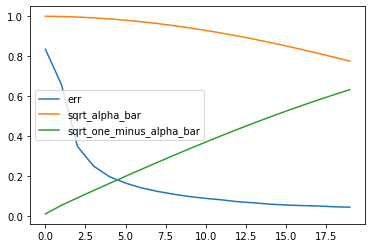

In [18]:
plt.plot(np.mean(np.abs(pred - noise.numpy()), axis=1), label='err')
plt.plot(np.sqrt(alpha_bar), label='sqrt_alpha_bar')
plt.plot(np.sqrt(1 - alpha_bar), label='sqrt_one_minus_alpha_bar')
plt.legend()

## Plot L1-loss

Plot L1-loss between denoised audios

In [19]:
def abs_err(inp): return np.mean(np.abs(diffused[:-1] - inp), axis=1)
de = abs_err(denoised)
ie = abs_err(inferenced)
ae = abs_err(ir)

&lt;matplotlib.legend.Legend at 0x1882d64dc50&gt;

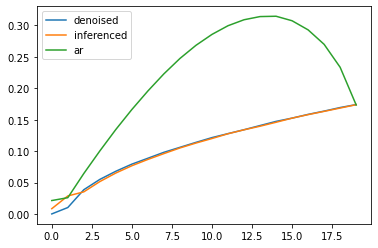

In [20]:
plt.plot(de, label='denoised')
plt.plot(ie, label='inferenced')
plt.plot(ae, label='ar')
plt.legend()

## Plot relative difference

Plot l1-loss relative to the magnitude

In [21]:
def rel_err(inp):
    return np.mean(
        np.abs(diffused[:-1] - inp) / np.abs(diffused[:-1]), axis=1)
de = rel_err(denoised)
ie = rel_err(inferenced)
ae = rel_err(ir)

&lt;matplotlib.legend.Legend at 0x18ab6a17390&gt;

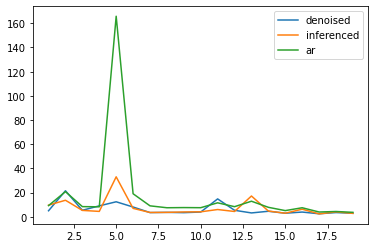

In [22]:
plt.plot(de, label='denoised')
plt.plot(ie, label='inferenced')
plt.plot(ae, label='ar')
plt.legend()